In [1]:
import sys
sys.path.append('..')

from VarPro import *
from resnet import *
import torchvision
import torchvision.transforms.v2 as transforms
from torchinfo import summary
import torch_optimizer

In [2]:
resnet = ResNet20(in_channels=3, num_classes=10)

In [3]:
optimizer = torch_optimizer.Shampoo(resnet.parameters(), lr=1e-3)

In [4]:
optimizer.step()

In [3]:
summary(resnet, input_size=(128, 3, 32, 32))

Layer (type:depth-idx)                        Output Shape              Param #
VarProModel                                   [128, 10]                 --
├─ResNetFeatureModel: 1-1                     [128, 64]                 --
│    └─Conv2d: 2-1                            [128, 16, 32, 32]         432
│    └─BatchNorm2d: 2-2                       [128, 16, 32, 32]         32
│    └─Sequential: 2-3                        [128, 16, 32, 32]         --
│    │    └─BasicBlock: 3-1                   [128, 16, 32, 32]         4,672
│    │    └─BasicBlock: 3-2                   [128, 16, 32, 32]         4,672
│    │    └─BasicBlock: 3-3                   [128, 16, 32, 32]         4,672
│    └─Sequential: 2-4                        [128, 32, 16, 16]         --
│    │    └─BasicBlock: 3-4                   [128, 32, 16, 16]         14,528
│    │    └─BasicBlock: 3-5                   [128, 32, 16, 16]         18,560
│    │    └─BasicBlock: 3-6                   [128, 32, 16, 16]         18,56

In [26]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./cifar10_data',
                                        train=True,
                                        download=True,
                                        transform=transform_train)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

In [4]:
lr = 0.1
lr_outer = 1

optimizer = torch.optim.SGD(resnet.feature_model.parameters(), lr=lr)
optimizer.add_param_group({'lr':lr_outer, 'params': resnet.outer.weight})

In [11]:
len(optimizer.param_groups[0]['params'])

63

In [27]:
inputs, targets = next(iter(train_loader))

In [29]:
resnet.train()
features = resnet.feature_model(inputs).clone().detach()
K = features.T @ features / (128 * resnet.width)
eigs = torch.linalg.eigvalsh(K)

In [30]:
eigs

tensor([1.3589e-05, 1.7258e-05, 1.9717e-05, 2.2558e-05, 2.3510e-05, 2.6498e-05,
        3.0294e-05, 3.2984e-05, 3.5156e-05, 3.8657e-05, 4.0876e-05, 4.5773e-05,
        4.7469e-05, 5.0658e-05, 5.7257e-05, 6.0873e-05, 6.7141e-05, 6.8490e-05,
        7.6432e-05, 7.9916e-05, 8.4277e-05, 8.6774e-05, 9.5045e-05, 1.0437e-04,
        1.0953e-04, 1.1668e-04, 1.2874e-04, 1.3311e-04, 1.3476e-04, 1.5180e-04,
        1.6005e-04, 1.6311e-04, 1.8554e-04, 2.0661e-04, 2.0896e-04, 2.3205e-04,
        2.5217e-04, 2.6833e-04, 2.8632e-04, 2.9998e-04, 3.3102e-04, 3.3513e-04,
        3.8025e-04, 4.0632e-04, 4.3050e-04, 5.2501e-04, 5.3300e-04, 5.9587e-04,
        6.3342e-04, 7.0085e-04, 7.1826e-04, 7.7026e-04, 9.5181e-04, 1.0302e-03,
        1.2381e-03, 1.3006e-03, 1.4931e-03, 1.6736e-03, 1.7862e-03, 2.3030e-03,
        2.8882e-03, 4.6772e-03, 2.3112e-02, 6.5812e-01])

(array([10., 16., 16., 11.,  8.,  1.,  1.,  0.,  0.,  1.]),
 array([-11.20621872, -10.12743378,  -9.04864883,  -7.96986437,
         -6.89107943,  -5.81229448,  -4.73351002,  -3.65472507,
         -2.57594013,  -1.49715519,  -0.41837031]),
 <BarContainer object of 10 artists>)

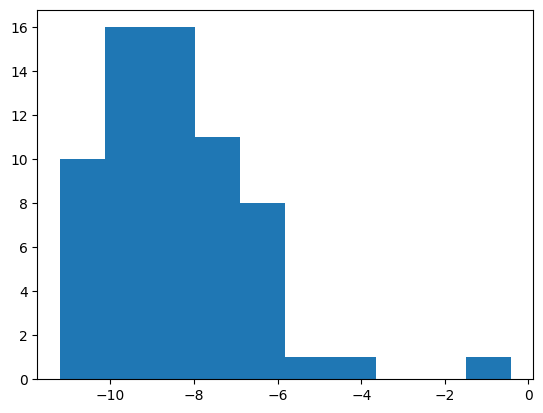

In [35]:
plt.hist(torch.log(eigs), bins=10)
#plt.yscale('log')
#plt.xscale('log')

In [5]:
## Training
lmbda = 1e-1
time_scale = 2**(-10)
lr = 512 * time_scale

# biased or unbiased loss
criterion = VarProCriterion(lmbda, num_classes=10)
                                   
optimizer = torch.optim.SGD(resnet.feature_model.parameters(), lr=lr)
#optimizer.add_param_group({'lr': 5*student_width*lmbda, 'params': student.outer.weight})

In [8]:
problem = LearningProblem(resnet, train_loader, optimizer, criterion)